# <a id='toc1_'></a>[OpenVINO XAI: Classification explanation](#toc0_)

This notebook shows an example how to use OpenVINO XAI.

**OpenVINO Explainable AI (XAI) Toolkit** provides a suite of XAI algorithms for visual explanation of
[OpenVINO™](https://github.com/openvinotoolkit/openvino) Intermediate Representation (IR) models.

It depicts a heatmap with areas of interest where neural network (classification or detection) focuses before making a decision. 

**Table of contents**<a id='toc0_'></a>    
- [OpenVINO XAI: Classification explanation](#toc1_)    
- [Imports](#toc2_)    
- [Get IR model](#toc3_)    
  - [Download and convert timm models (Optional)](#toc3_1_)    
  - [Download prepared IR from the storage](#toc3_2_)    
- [Insert XAI branch](#toc4_)    
  - [Read the model](#toc4_1_)    
  - [Default settings](#toc4_2_)    
  - [Set up insertion parameters](#toc4_3_)    
- [Create model inferrer](#toc5_)    
  - [Create CustomInferrer](#toc5_1_)    
  - [Get raw saliency maps from model inference pipeline](#toc5_2_)    
- [Explain model](#toc6_)    
  - [White Box explainer](#toc6_1_)    
  - [Black Box explainer](#toc6_2_)    
  - [Explain model for multiple images](#toc6_3_)    
  - [Import ImageNet label names and add them to saliency maps](#toc6_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [1]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino.runtime as ov

import openvino_xai as ovxai
from openvino_xai.common.parameters import TaskType, XAIMethodType
from openvino_xai.common.utils import retrieve_otx_model
from openvino_xai.explanation.explanation_parameters import (
    ExplainMode, ExplanationParameters, PostProcessParameters,
    TargetExplainGroup)
from openvino_xai.explanation.explanation_result import ExplanationResult
from openvino_xai.explanation.utils import InferenceResult
from openvino_xai.insertion.insertion_parameters import \
    ClassificationInsertionParameters

# <a id='toc3_'></a>[Get IR model](#toc0_)

To get the model for explanation you can download and convert your own or use it from `timm`. **It will require installing additional libraries.**

To simplify the notebook running, you can skip it and pass to [Download prepared IR from the storage](#toc3_2_) 
chapter and download the converted model from OpenVINO storage.

## <a id='toc3_1_'></a>[Download and convert timm models (Optional)](#toc0_)
You can download and convert to IR models from timm, but  it will require downloading `timm` and `torch`.

In [2]:
# Install torch (update CUDA version in --extra-index-url if needed)
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch
%pip install -q -r ../../requirements/dev_timm.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import timm
import torch

In [4]:
# Will use `mobilenetv3_large_100.ra_in1k` model as an example in this notebook
model_name = "mobilenetv3_large_100.ra_in1k"
timm_model = timm.create_model(
    model_name, in_chans=3, pretrained=True, checkpoint_path=""
)

timm_model_dir = Path("./otx_models/timm_models")
timm_model_dir.mkdir(parents=True, exist_ok=True)

model_path = timm_model_dir / model_name
onnx_model = f"{model_path}.onnx"
ir_model = f"{model_path}.xml"

To try another `timm` model, check the list of supported models using `timm.list_models()`.

In [5]:
from openvino_xai.utils.timm_models_export import export_to_ir, export_to_onnx

input_size = [1] + list(timm_model.default_cfg["input_size"])
dummy_tensor = torch.rand(input_size)

export_to_onnx(timm_model, onnx_model, dummy_tensor, set_dynamic_batch=False)
export_to_ir(onnx_model, ir_model)

model_path = ir_model

The IR model will be saved together with ONNX model in `timm_model_dir` directory

## <a id='toc3_2_'></a>[Download prepared IR from the storage](#toc0_)

Alternative way is to download already converted to IR model from OpenVINO storage, that will be used as an example in this notebook. That model originally from timm storage and requires timm preprocessing.

In [6]:
# Download test IR (.bin+.xml) model from our repository or use your own
retrieve_otx_model(
    ".",  # Destination folder
    "mobilenetv3_large_100.ra_in1k",  # Model name
    dir_url="https://storage.openvinotoolkit.org/repositories/openvino_training_extensions/models/custom_image_classification",
)

# Please manually check the size of the downloaded model to be more than 2 KB
model_path = "./otx_models/mobilenetv3_large_100.ra_in1k.xml"

# <a id='toc4_'></a>[Insert XAI branch](#toc0_)

## <a id='toc4_1_'></a>[Read the model](#toc0_)

In [7]:
# Create original ov.Model
model: ov.Model
model = ov.Core().read_model(model_path)

## <a id='toc4_2_'></a>[Default settings](#toc0_)

In [8]:
# Insert XAI branch
model_xai: ov.Model
model_xai = ovxai.insert_xai(
    model,
    task_type=TaskType.CLASSIFICATION,
)

INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.


In [9]:
# Insertion XAI branch means that model now have an additional output called `saliency_map`
model_xai.outputs

[<Output: names[498] shape[1,1000] type: f32>,
 <Output: names[saliency_map] shape[1,1000,7,7] type: u8>]

By default, the insertion of XAI branch will be done automatically by searching correct node. 

If method wasn't specifed, XAI branch will be generated with [ReciproCAM](https://arxiv.org/abs/2209.14074) method. It provides saliency map for each class that model is able to predict (1000 classes ImageNet case).

## <a id='toc4_3_'></a>[Set up insertion parameters](#toc0_)

If automatic search for correct node fails, you can set up a correct node manually with `target_layer` argument. For classification it's the last backbone node with shape [-1, num_channels, feature_map_height, feature_map_width]. For example, for MobileNetV3 it will be `/backbone/conv/conv.2/Div` layer with [-1, 960, 7, 7] input shape.

`embed_normalization` **default True** (for speed purposes), this parameter adds normalization to the XAI branch, which results in being able to visualize saliency maps right away without further postprocessing.

`explain_method_type` can be:

- `XAIMethodType.RECIPROCAM` - to receive per-class saliency maps
- `XAIMethodType.ACTIVATIONMAP` - to receive one saliency map for all classes that shows zones of model's attention

In [10]:
# Define insertion parameters
insertion_parameters = ClassificationInsertionParameters(
    target_layer="/blocks/blocks.6/blocks.6.0/bn1/act/HardSwish",
    # target_layer="/backbone/conv/conv.2/Div",  # OTX mnet_v3
    # target_layer="/backbone/features/final_block/activate/Mul",  # OTX effnet
    embed_normalization=True,
    explain_method_type=XAIMethodType.RECIPROCAM,
)

# Create original ov.Model
model = ov.Core().read_model(model_path)

# insert XAI branch
model_xai: ov.Model
model_xai = ovxai.insert_xai(
    model,
    task_type=TaskType.CLASSIFICATION,
    insertion_parameters=insertion_parameters,
)

INFO:openvino_xai:Target insertion layer /blocks/blocks.6/blocks.6.0/bn1/act/HardSwish is provided.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Insertion of the XAI branch into the model was successful.


# <a id='toc5_'></a>[Create model inferrer](#toc0_)

After the model is updated with explainable AI branch, it can be used in your own pipelines. For example, let's create a custom inferencer similarly to those that can be done in personal product pipelines.
## <a id='toc5_1_'></a>[Create CustomInferrer](#toc0_)




For example of creating callable `CustomModelInferrer` class, that can be updated based on your pipeline, refer to [model_inferrer.py](../../openvino_xai/explanation/model_inferrer.py)

```python
model_inferrer = ovxai.explanation.model_inferrer.ClassificationModelInferrer(model_xai)
# Usage:
inference_result = model_inferrer(image)  # inference_result: ovxai.explanation.utils.InferenceResult
```

For creating a basic model_inferrer see example below

In [13]:
def preprocess(x: np.ndarray, mean: np.array, std: np.ndarray) -> np.ndarray:
    # Resize to imagenet image shape.
    x = cv2.resize(src=x, dsize=(224, 224))
    x = (x - std) / mean
    # Reshape to model input shape to [batch, channels, height, width].
    x = x.transpose((2, 0, 1))
    x = np.expand_dims(x, 0)
    return x


def postprocess(x: np.ndarray) -> np.ndarray:
    # Process model prediction
    prediction_processed = softmax(x)
    return prediction_processed


def softmax(x):
    """Compute softmax values of x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def sigmoid(
    x,
):  # In case of multilabel classification you can update `preprocess` function and use sigmoid
    """Compute sigmoid values of x."""
    return 1 / (1 + np.exp(-x))

In [14]:
class ClassificationModelInferrer:
    """
    Example of the custom model inferrer implementation.

    Args:
        model (ov.Model): IR model.
        is_timm_model (bool): Flag whether to use timm preprocessing mean, std values. Default: False
    """

    def __init__(self, model: ov.Model, is_timm_model: bool = False):
        self.compiled_model = ov.Core().compile_model(model, "CPU")

        self.is_timm_model = is_timm_model
        # Values for timm models preprocessing
        self.mean = (
            np.array([123.675, 116.28, 103.53])
            if is_timm_model
            else np.array([0.0, 0.0, 0.0])
        )
        self.std = (
            np.array([58.395, 57.12, 57.375])
            if is_timm_model
            else np.array([1.0, 1.0, 1.0])
        )

    def __call__(self, x: np.ndarray) -> InferenceResult:
        x = preprocess(x, mean=self.mean, std=self.std)
        result = self.compiled_model(x)

        logits = result[0]
        logits = postprocess(logits)

        # "saliency_map" is an additional model output added during insertion XAI branch
        if "saliency_map" in result:
            raw_saliency_map = result["saliency_map"]
        else:
            raw_saliency_map = None

        inference_result = InferenceResult(logits, raw_saliency_map)
        return inference_result

In [15]:
model_inferrer = ClassificationModelInferrer(model_xai, is_timm_model=True)

## <a id='toc5_2_'></a>[Get raw saliency maps from model inference pipeline](#toc0_)

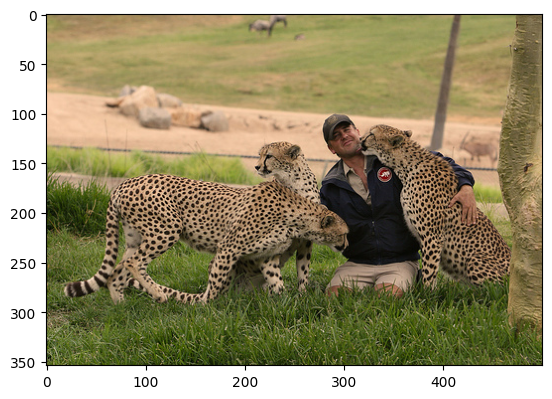

In [16]:
# Get the image
image_path = "../../tests/assets/cheetah_person.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [17]:
# Get raw saliency map via model_inferrer call
inference_result = model_inferrer(cv2.imread(image_path))
raw_saliency_map = inference_result.saliency_map
print(raw_saliency_map.shape)  # 1x1000x7x7 uint8 np.array

(1, 1000, 7, 7)


Resulting output contain saliency maps for each of 1000 classes. See gray-scale low-resolution for `cheetah` class below (zones of attention are highlighted white): 

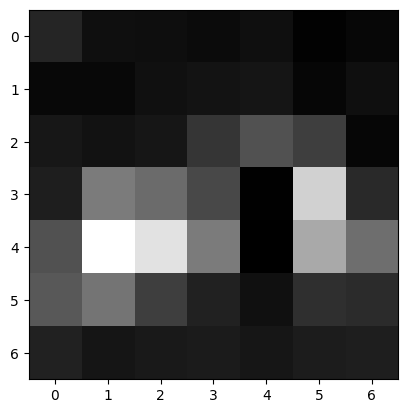

In [18]:
cheetah_class_index = 293
cheetah_raw_sal_map = raw_saliency_map[0][cheetah_class_index]
cheetah_raw_sal_map = cv2.cvtColor(cheetah_raw_sal_map, cv2.COLOR_BGR2RGB)

plt.imshow(cheetah_raw_sal_map)
plt.show()

# <a id='toc6_'></a>[Explain model](#toc0_)

For more convenient saliency map processing, you can use OpenVINO XAI API:
- To return saliency maps only for predicted classes using `TargetExplainGroup.PREDICTIONS`
- To return predictions and its confidence with `explanation.prediction`
- To apply built-in postprocessing with overlay/resize using `PostProcessParameters`
- To choose mode for explaining (whitemode or blackmode) using `ExplainMode`

## <a id='toc6_1_'></a>[White Box explainer](#toc0_)

The White-Box explainer treats model as a white box and needs to make inner modifications. It adds extra XAI nodes after backbone to estimate which activations are important for model prediction.

It works fast and precise and requires only one model inference.

In [19]:
image_path = "../../tests/assets/cheetah_person.jpg"
image_name = Path(image_path).stem

In [20]:
# Create explanation parameters, default parameter values are highlighted below
explanation_parameters = ExplanationParameters(
    explain_mode=ExplainMode.WHITEBOX,  # by default, run white-box XAI
    # by default, explains only predicted classes
    target_explain_group=TargetExplainGroup.PREDICTIONS,
    # by default, saliency map overlays over image
    post_processing_parameters=PostProcessParameters(overlay=True),
)

In [21]:
# Generate processed saliency map via .explain(model_inferrer, image) call
explanation = ovxai.explain(
    model_inferrer=model_inferrer,
    data=cv2.imread(image_path),
    explanation_parameters=explanation_parameters,
)
explanation: ExplanationResult
explanation.saliency_map  # Dict[int: np.ndarray] where key - class id, value - processed saliency map e.g. 354x500x3

print(
    f"Saliency maps were generated for the following classes: {list(explanation.saliency_map.keys())}"
)
print(f"Saliency map size: {explanation.sal_map_shape}")

Saliency maps were generated for the following classes: [293]
Saliency map size: (354, 500, 3)


In [22]:
# Get saliency map of the correct class
cheetah_class_index = 293
cheetah_sal_map = explanation.saliency_map[cheetah_class_index]
cheetah_sal_map = cv2.cvtColor(cheetah_sal_map, cv2.COLOR_BGR2RGB)
print(f"Processed saliency map shape: {cheetah_sal_map.shape}")

Processed saliency map shape: (354, 500, 3)


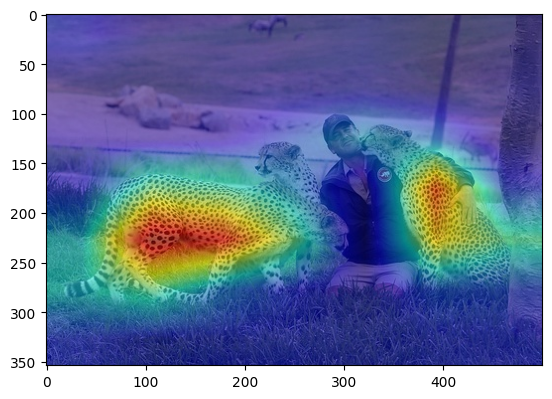

In [23]:
# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/whitebox_explain"
explanation.save(output_dir, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_293.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

In case of explanation `explain_method_type==XAIMethodType.ACTIVATIONMAP`, instead of saliency map for each class the activation map is returned as `explanation.saliency_map["per_image_map"]`.

## <a id='toc6_2_'></a>[Black Box explainer](#toc0_)

The Black Box treats the model as a black box without altering its structure. So, this method will work on any model that can be inferred and return the class probabilities as output.

The [RISE](https://arxiv.org/pdf/1806.07421.pdf) algorithm used for BlackBox applies random masks to hide parts of the image, gets result class probabilities and by that calculates the "importance" of each part of the image for final results. After a few thousands of inferences the summarized saliency map is generated.

Although it's convenient to predict every model as a black-box, this explain algorithm might require many inferences (5000 by default) to generate high-quality saliency map.

In [24]:
# BlackBox explainer has an additional set of parameters
black_box_method_kwargs = {
    "num_masks": 1000,  # more masks will make saliency maps better but will take longer
    "num_cells": 8,  # decrease to highlight smaller objects,
    "asynchronous_inference": False,  # swich on asynch mode for faster inference
    "throughput_inference": False,
}

# Create explanation parameters for Black Box explainer
explanation_parameters = ExplanationParameters(
    explain_mode=ExplainMode.BLACKBOX, black_box_method_kwargs=black_box_method_kwargs
)

In [25]:
# The rest of explanation process for is the same as for WhiteBox

# Generate processed saliency map via .explain(model_inferrer, image) call
explanation = ovxai.explain(
    model_inferrer=model_inferrer,
    data=cv2.imread(image_path),
    explanation_parameters=explanation_parameters,
)
explanation: ExplanationResult
explanation.saliency_map  # Dict[int: np.ndarray] where key - class id, value - processed saliency map e.g. 354x500x3

print(
    f"Saliency maps were generated for the following classes: {list(explanation.saliency_map.keys())}"
)
print(f"Saliency map size: {explanation.sal_map_shape}")

Explaining in synchronous mode: 100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s]


Saliency maps were generated for the following classes: [293]
Saliency map size: (354, 500, 3)


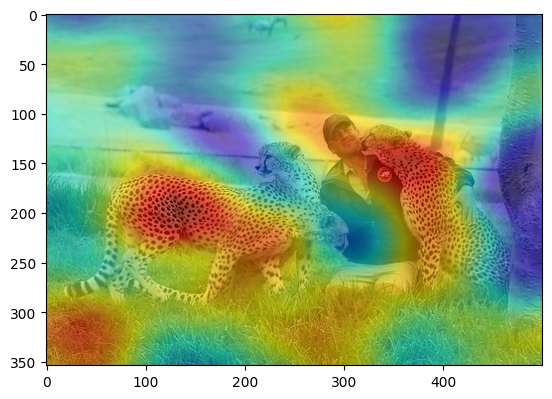

In [26]:
# Save saliency maps stored in `explanation` object
output_dir = "saliency_map/blackbox_explain"
explanation.save(output_dir, image_name)

# See saved saliency maps
image_sal_map = cv2.imread(f"{output_dir}/{image_name}_target_293.jpg")
image_sal_map = cv2.cvtColor(image_sal_map, cv2.COLOR_BGR2RGB)
plt.imshow(image_sal_map)
plt.show()

For `BlackBox explainer` the number of masks and cells is crucial for good result. On the example above we see that number of masks wasn't enough for qualitive enough map.

 Varying `num_cells`/`num_masks` parameters can achieve different goals:
- To speed up the explanation, we can reduce the number of `num_mask`. But the result saliency maps will decrease the quality, so this option can be used for big and focused objects.
- The more `num_cells` we have, the more fine-grained result we can expect. But more `num_cells` requires bigger `num_masks` to converge. This would work better work for classes with complex shape.

## <a id='toc6_3_'></a>[Explain model for multiple images](#toc0_)

To run explanations on the list of images from the specific folder, pass its name as `image_folder_path`:

In [27]:
# Create list of images
img_data_formats = (".jpg", ".jpeg", ".JPEG", ".gif", ".bmp", ".tif", ".tiff", ".png")

img_files = []
image_folder_path = "../../tests/assets"
output = Path("saliency_map/test_images")

# image_folder_path is a directory (with sub-folder support)
for root, _, _ in os.walk(image_folder_path):
    for format_ in img_data_formats:
        img_files.extend(
            [os.path.join(root, file.name) for file in Path(root).glob(f"*{format_}")]
        )

print(f"Number of images to get explanations: {len(img_files)}")

Number of images to get explanations: 2


In [28]:
# Create explanation_parameters
explanation_parameters = ExplanationParameters(
    post_processing_parameters=PostProcessParameters(overlay=True),
)

# Run explanation on images in "image_folder_path"
for image_path in img_files:
    image = cv2.imread(image_path)
    try:
        explanation = ovxai.explain(
            model_inferrer=model_inferrer,
            data=image,
            explanation_parameters=explanation_parameters,
        )
        explanation.save(output, Path(image_path).stem)
    except ValueError:
        print(f"Explanation for {image_path} has no predictions")

Explanation for ../../tests/assets/blood.jpg has no predictions


In [29]:
# See saliency maps saved in `output`
! ls -l $output

total 84
-rw-r--r-- 1 gzalessk gzalessk 78967 Feb  7 18:10 cheetah_person_target_293.jpg
drwxr-xr-x 2 gzalessk gzalessk  4096 Jan  6 17:54 label_names


From 2 images in folder, one of them returned predictions and saliency map for predicted 293 class for `cheetah_person.jpg` image.
For `blood.jpg` model couldn't find any object and didn't save any saliency map, since `TargetExplainGroup.PREDICTIONS` was chosen by default.

## <a id='toc6_4_'></a>[Import ImageNet label names and add them to saliency maps](#toc0_)

If model doesn't have a label list in meta information, the saved saliency map will have the predicted class index, not name. For example,  `cheetah_person_target_293.jpg` instead of `cheetah_person_target_cheetah.jpg`. 

To see the predicted label name more conveniently, let's add ImageNet label list info into explaination parameters. 

In [30]:
! wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-02-07 18:10:41--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving proxy-dmz.intel.com (proxy-dmz.intel.com)... 10.184.220.176
Connecting to proxy-dmz.intel.com (proxy-dmz.intel.com)|10.184.220.176|:912... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.01s   

2024-02-07 18:10:41 (757 KB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [31]:
# Get ImageNet labels to add them to explanations
f = open("imagenet_classes.txt", "r")
imagenet_labels = []
for label in f.readlines():
    class_label = label.replace(" ", "_")[:-1]
    imagenet_labels.append(class_label)

print(" ".join(imagenet_labels[:10]))

tench goldfish great_white_shark tiger_shark hammerhead electric_ray stingray cock hen ostrich


In [32]:
# Create explanation_parameters, adding list with ImageNet labels
explanation_parameters = ExplanationParameters(
    post_processing_parameters=PostProcessParameters(overlay=True),
    explain_target_names=imagenet_labels,
)

# Explain model and save results using ImageNet label names
for image_path in img_files:
    image = cv2.imread(image_path)
    try:
        explanation = ovxai.explain(
            model_inferrer=model_inferrer,
            data=image,
            explanation_parameters=explanation_parameters,
        )
        explanation.save(output / "label_names", Path(image_path).stem)
    except ValueError:
        pass

Below in `output / "label_names"` you can see saved saliency maps:

In [33]:
# See saliency mas saved in `output` with predicted label in image name
! ls -l $output/label_names

total 80
-rw-r--r-- 1 gzalessk gzalessk 78967 Feb  7 18:10 cheetah_person_target_cheetah.jpg
